# Semester Project:
# exploring Differentiable Neural Computers and applications

## Introduction
What we want to present in the following notebook is a cutting-edge topic in machine learning, related to a particular model of Neural Network called **Differentable Neural Computer** (DNC) which puts together a Neural Network and an external memory from which the Netwoek can read and write. The main source of this noteboook is based on the article and paper which can be found [here](https://deepmind.com/blog/differentiable-neural-computers/).
<br>

We start with a presentation of the DNC and how they are enhanced form *Neural Turing Machines*. Then we move to the core topic of this networks which are the three **differentiable attention mechanisms** with whihc the network performs the read and writes operations. We propose then a code for the implementation of these Networks, testing their performances and limitations. Finally we will try to implement the graph task presented in the paper and adapt it to a different problem.
<hr>

## DNC
The Differentiable Neural Computers are neural networks with a coupled memory, where the dimension of this memory does not affect the behaviour of the network. The memory can be tought as a RAM and the Network as a controller which is differentiable using gradient descent-like tecniques.
<br>
Comparing this Network with the respect of other whihc present memory states such as RNN or LSTM, DNCs do not store information whihc is tigth coupled with the model itself. Instead, they have the possibility to selectively read and write to and from memory locations, creating a separation between state preservation and content (data).
<br>

In the litterature, another network capable of read and write using an external memory came out in the past, called **Neural Turing Machine** (NTM). Altought the concept is similar to the DNC, with a Network acting as controller and an external memory, they are more restricted in the method with which the Neural Network access the memory. 

<br>
![DNC](./figures/DNC_architecture.png)
<br>

The image shows the architecture of a DNC Neural Network. In this specif example, the controller is a Recursive Neural Network (a LSTM is also possible) which is receiving an input (from a dataset) and the previous step readings from the memory. The output of the network is made of two parts:
- The output of the Neural Network, which constitute our target
- A vector called **'Interface Vector'** which is used by the read and write heads to interact with the memory

As it's clear by now, the DNC is mainly composed of two parts interacting together: the **Neural Netwoerk** itself (**a**) and the **Heads** (**b**) which performs the operations over the **Memory** (**c**). Those oprations are the key differences of DNC over NTM and will be described in details in the next paragraph. 

The Heads are particular components which are dealing with the content of the memory. It's possible to define as many read and write heads as needed, all of them will receive weights vector which are used to define the location over which perform the read and write operations. The differentiability of these parts allows the network to learn how to perform these operations simple by looking at the error during the trainign process and adjusting the weights.

Finally, in addition to the Memory there is an additional information whcih is saved and used during the read and writes operations. Those are the **Memory Usage and Temporal Links** (**d**) which is an imprvement over the NTM. Those links and usage information allows to dynamically allocate the content during the reads and to have notion of temporal assosciation between entries of the memory. That is, it's possibile to know the sequence of the writtings which is extremely important when the Network has to deal to sequential tasks such as graph path search.
<hr>


## Memory Interactions

### Overview
The core mechanism of DNCs is the possibility to write and read from an external memory matrix. As mentioned, the difference with the NTMs is in defining more **attention mechanisms**. This is different from the address mechanisms in conventional computers, where there is a mapping between the address and the content of the memory. The idea here is to define the weights over the location of the Memory. Those weights represents a degree (we can immagine it has a filter) that indicates how much the locations in the Memory matrix are involved during read and writing operations.
<br>
Briefly:
- a read vector $\mathbf{r}$ is returned after a read operation which involves a read weights matrix $\mathbf{w^r}$:<br>
    $\mathbf{r}=\sum_{i=1}^N M[i,j]w^r[i]$ for $j=1, \dots,W$
    
- an erase vector $\mathbf{e}$ is applied using the write weights matrix $\mathbf{w^w}$, then a a write vector is added $\mathbf{v}$:<br>
    $\mathbf{v}: M[i,j] \leftarrow M[i,j](1-\mathbf{w^w}[i]\mathbf{e}[j]+\mathbf{w^w}[i]\mathbf{v}[j])$

The units which determines this operations are the read and write Heads. 

### Differentiable Attention
There are three forms of differentiable attention. This is more a fancy terminology to call the three pricipal techniques involved in in order to address the memory. Before going into the details we want to recall some of the techniques which are instead used in NTM to appreasciate the difference with the DNC. 

There are two mechanism for addressing the memory and the Neural Tuning Machines combines both:
- *content-based addressing*: focuses attention on locations based on the similarity between their current values and values emitted by the controller. This is related to the content addressing of the Hopfield networks, the controller needs to generate a value which is an approximation of the one stored to then retrieve the exact location. 
- *location-based addressing*: it's the traditional approach to address the memory. For arithmetic operation where we need to define variables the conent based in not enough, we need the location of the variable to perform the operation.

Differentiable Neural Computers uses a *content-based addressing* paired with other two techniques which allows for a **Dynamic Memory Addressing** counteracting the major drawbacks of the NTM:
1. NTMs do not avoid possible overlapping and interfere among blocks of allocating memory. DNCs instead overcame this problem due to there is only a single free at each write time.
2. NTMs does not allow for freeing location of memory which are not used and this can be a problem when processing long sequences. DNCs instead can free memory locations based on the usage weights.
3. NTMs sequential information is preserved only if the content is written in consecutive locations. DNCs uses an additional temporal link matrix avoidin the restriction to continuous locations only. 

For now we explain the concepts of these three differentiable attention. A more detailed analysis will be given in the following paragraphs

#### Content base addressing
This form is used to determine the similarity measure between the vector emmited by the controller and the content of the memory. The measure is a cosine similarity function that returns weights which are then used by the read head for associative recall or by the write head to modify the conetent of the memory. In addition, if the key only match a part of the conentent of the memory this is still useful and can lead to the retrieval of that location. This may be due to the key may not have all the information which instead are stored in the memory.

#### Temporary links
This form keep track of the transitions betweens locations which were consecutively written using an $LxL$ temporal *link matrix* $L$. This matrix associate a weight from 0 to 1 for each pair of locations in the matrix, where the entry $L[i,j]$ is the temporal relation between the location $i$ and $j$. The weight is closer to $1$ if the locations $i$ was written after $j$, otherwise the value is closer to $0$. This gives to the Neural Network the ability to recover sequences following the order under which they were written.
<br>

The product $L\mathbf{w}$ creat a smoothing effect, shifting the focus forwards the locations after those emphasized by $\mathbf{w}$. That is, after a writting which is based on $\mathbf{w}$

#### Usage 
This form is used to allocate the memory for writting. The usage is a value between $0$ and $1$, with a weighting to select unsued locations that is delivered to the writing head. The usage is incremented after each write to that location and decreased after each read. The good property is that this is independent from the memory size and content. This allows the network to be trained and then upgrade to a larger one.

<hr>

## Details
### TODO
Includere i dettagli della DNC

<hr>

## Implementation
The code has been taken from [github](https://github.com/deepmind/dnc). The idea is to analyse it and further modify or add some parts of the implementation in order to achieve our goals. For now we just list the major modules which are used to implement the DNC. Then we will used the *Repeat Copy Task* to perfrom some tests on the DNC. The final goal from the implementation point of view is to extend this one with the *Graph Task*
<br>
The modules provided are the following:
- **Addressing and Access  Modules**
    The following code implements the addressing methods discussed above. In addition another script provides the function necessary to manipulate the memory exploiting the addressing methods already defined.
- **DNC Module**
    The following code represents the core of the Differentiable Neural Computer. This is an extention of the class RNN core, which include also the manipulation with the memory. We have to reming that the Controller is implemented as LSTM reccurent network.
- **Repeat Copy Task**
    The folowing code is used to create a dataset for the copy task. The DNC receives in input batches of collections of string which have to be copied a number of times which is defined randomly.
- **Training Module** 
    Finally the code for the trainig is porvided. This code allows also to save the variables of the model for checkpoint it and restore the values for an input evaluation. Note that the variables are saved and not the model, this mean that it's needed to reacreate the graph then loead the variables during a session.

<br>
Here follows the code license:

```python
# ==========================================================================
# Copyright 2017 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==========================================================================
```

## Tests
To performs some test on the model we had to modify the way the dataset was originted. The first test is to understand how much the model is sensitive to noised data. We have taken the original generation code and applied some modifications. For random betchs (where the randomness is further explained) we flipped the values of the bit in the string to copy alterning the target. That is, to deceive the DNC to perform it's original task of copying a string of bits several times we have changed the target. So we let the DNC assume it made it wrong and underdtand if for some samples this may cause a non convergence of the error to 0.
<br>
Before analysizing the noised version we have to test the DNC in a normal copy task with non altered target values. We can exploit the modified code in order to create the training environment over which manipulate the DNC training which allows for both non noised and noised training.

In [42]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from sklearn.neighbors import NearestNeighbors
from scipy.sparse import random as r_sparse

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats as sts
import time
import random
import collections
import argparse
import os
import shutil

In [43]:
import _dnc

#### Dataset Class
Here we have defined a new class for building the dataset related to the **copy task**. The idea is to include some noise to both the observations and the targets and see how the DNC will behave with these data in comaparison with the normal one. The dataset is different with the respect of the one in the paper due to here we are not adding operation to the graph directly. Instead we are materializing the data which will be fed during each training iteration throughout the *tf.Session*.

In [61]:
class DataRepeatCopy(object):
    """TODO"""
    def __init__(self, num_bits=6, batch_size=1, min_length=1, max_length=1, min_repeats=1, max_repeats=2,
                 norm_max=10, log_prob_in_bits=False, time_average_cost=False, noise_targ_level=None,
                 noise_obs_level=None):
        self._batch_size = batch_size
        self._num_bits = num_bits
        self._min_length = min_length
        self._max_length = max_length
        self._min_repeats = min_repeats
        self._max_repeats = max_repeats
        self._norm_max = norm_max
        self._log_prob_in_bits = log_prob_in_bits
        self._time_average_cost = time_average_cost
        self._noise_targ_level = noise_targ_level
        self._noise_obs_level = noise_obs_level

    def build_dataset(self):
        """TODO"""
        # one bit extra for the number of repetitions and one for the start marker
        total_obs_bits = self._num_bits + 2
        # one bit extra fir the end marker in the targets
        total_targ_bits = self._num_bits + 1
        # indexed for the start channel and the repetition one
        start_flag_idx = total_obs_bits - 2
        rep_flag_idx = total_obs_bits - 1
        end_flag_idx = total_targ_bits - 1

        # draw from a uniform distribution the length of the sequences for each batch
        sequence_lengths = np.random.randint(low=self._min_length, high=self._max_length + 1,
                                             size=self._batch_size, dtype=np.int8)
        # draw from a uniform distribution the number of repetition of the sequences for each batch
        repetitions = np.random.randint(low=self._min_repeats, high=self._max_repeats + 1,
                                        size=self._batch_size, dtype=np.int8)

        # includes the observation + target and the three extra channels
        total_length_batch = sequence_lengths * (repetitions + 1) + 3
        # determine the max length of the batch to make all batch the same length (pad with zeros)
        max_length_batch = np.max(total_length_batch)
        # compute the residuals for each batch
        residual_length_batch = max_length_batch - total_length_batch

        obs_tensors = []
        obs_noised_tensors = []
        targ_tensors = []
        targ_noised_tensor = []
        mask_tensors = []

        for batch_index in range(self._batch_size):
            seq_length = sequence_lengths[batch_index]
            repet = repetitions[batch_index]

            # create the observation pattern by sampling from a random distribution and reshape the array
            # use the previous computed sequence_length
            obs_pattern_shape = [seq_length, self._num_bits]
            obs_pattern = np.random.randint(low=0, high=2, size=obs_pattern_shape, dtype=np.int8)

            # create a noised version of the observations
            obs_pattern_noised = None
            if self._noise_obs_level is not None:
                noise = np.random.normal(loc=0, scale=self._noise_obs_level,
                                         size=obs_pattern_shape)
                # add the noise to the observations with non negative terms
                obs_pattern_noised = obs_pattern + np.abs(noise)
                # rescale to have values between 0 and 1
                obs_pattern_noised = obs_pattern_noised / np.max(obs_pattern_noised)

            # the target pattern is the observation one repeated n times
            targ_pattern_reps = [repet, 1]
            targ_pattern = np.tile(obs_pattern, reps=targ_pattern_reps)

            # create a noisy version
            targ_pattern_noised = None
            if self._noise_targ_level is not None:
                class CustomRandState(np.random.RandomState):
                    def randint(self, low, high=None, size=None, dtype='l'):
                        i = np.random.randint(low)
                        return i - i % 2

                # generate a sparse matrix with -1
                noise = r_sparse(targ_pattern.shape[0], targ_pattern.shape[1], density=self._noise_targ_level,
                                 random_state=CustomRandState(), data_rvs=sts.randint(-1, 0).rvs)
                # subtract the noise and then compute the absolute value bitwise. In this way if the bit was a 0
                # it becomes 1 or vice versa
                targ_pattern_noised = np.abs(targ_pattern + noise.A)

            # create the two extra channels for the flags, then concatenate to the observation
            obs_pat_ch_pad = np.zeros([seq_length, 2])
            # create the two extra columns to handle the flags
            obs_start_flag = np.zeros([1, total_obs_bits])
            obs_start_flag[0, start_flag_idx] = 1
            obs_rep_flag = np.zeros([1, total_obs_bits])
            obs_rep_flag[0, rep_flag_idx] = self._normalise(repet)

            # concatenate the extra channels and columns to the original observation pattern
            obs = np.concatenate((obs_pattern, obs_pat_ch_pad), axis=1)
            obs = np.concatenate((obs_start_flag, obs, obs_rep_flag), axis=0)

            obs_n = None
            if self._noise_obs_level is not None:
                obs_n = np.concatenate((obs_pattern_noised, obs_pat_ch_pad), axis=1)
                obs_n = np.concatenate((obs_start_flag, obs_n, obs_rep_flag), axis=0)

            # do the same for the target pattern
            # create the one extra channel for the end channel
            targ_pat_ch_pad = np.zeros([seq_length * repet, 1])
            targ_end_flag = np.zeros([1, total_targ_bits])
            targ_end_flag[0, end_flag_idx] = 1

            # concatenate the extra channels and columns to the original observation pattern
            targ = np.concatenate((targ_pattern, targ_pat_ch_pad), axis=1)
            targ = np.concatenate((targ, targ_end_flag), axis=0)

            targ_n = None
            if self._noise_targ_level is not None:
                targ_n = np.concatenate((targ_pattern_noised, targ_pat_ch_pad), axis=1)
                targ_n = np.concatenate((targ_n, targ_end_flag), axis=0)

            # create the zero pads which are included at the end for the obs pattern
            # and at the begging of the target
            obs_end_pad = np.zeros([seq_length * repet + 1, total_obs_bits])
            targ_start_pad = np.zeros([seq_length + 2, total_targ_bits])

            # create the mask which should be zero for the observation and one for the target
            mask_off = np.zeros([seq_length + 2])
            mask_on = np.ones([seq_length * repet + 1])

            obs = np.concatenate((obs, obs_end_pad), 0)
            targ = np.concatenate((targ_start_pad, targ), 0)
            mask = np.concatenate((mask_off, mask_on), 0)
            # noised versions
            if self._noise_obs_level is not None:
                obs_n = np.concatenate((obs_n, obs_end_pad), 0)
            if self._noise_targ_level is not None:
                targ_n = np.concatenate((targ_start_pad, targ_n), 0)

            obs_tensors.append(obs)
            targ_tensors.append(targ)
            mask_tensors.append(mask)
            # noised versions
            if self._noise_obs_level is not None:
                obs_noised_tensors.append(obs_n)
            if self._noise_targ_level is not None:
                targ_noised_tensor.append(targ_n)

        # padding of the sequences to have the same length
        residual_obs_pad = [
            np.zeros([residual_length_batch[i], total_obs_bits])
            for i in range(self._batch_size)
        ]
        residual_targ_pad = [
            np.zeros([residual_length_batch[i], total_targ_bits])
            for i in range(self._batch_size)
        ]
        residual_mask_pad = [
            np.zeros([residual_length_batch[i]]) for i in range(self._batch_size)
        ]

        # concatenate the pad to each batch element
        obs_tensors = np.array([
            np.concatenate((o, p), 0) for o, p in zip(obs_tensors, residual_obs_pad)
        ])
        targ_tensors = np.array([
            np.concatenate((t, p), 0) for t, p in zip(targ_tensors, residual_targ_pad)
        ])
        mask_tensors = np.array([
            np.concatenate((m, p), 0) for m, p in zip(mask_tensors, residual_mask_pad)
        ])

        # noised versions
        if self._noise_obs_level is not None:
            obs_noised_tensors = np.array([
                np.concatenate((o, p), 0) for o, p in zip(obs_noised_tensors, residual_obs_pad)
            ])
        if self._noise_targ_level is not None:
            targ_noised_tensor = np.array([
                np.concatenate((t, p), 0) for t, p in zip(targ_noised_tensor, residual_targ_pad)
            ])

        # create time-major batches
        obs = np.swapaxes(obs_tensors, 0, 1)
        targ = np.swapaxes(targ_tensors, 0, 1)
        mask = np.swapaxes(mask_tensors, 0, 1)

        # noised versions
        if self._noise_obs_level is not None:
            obs_n = np.swapaxes(obs_noised_tensors, 0, 1)
        else:
            obs_n = None
        if self._noise_targ_level is not None:
            targ_n = np.swapaxes(targ_noised_tensor, 0, 1)
        else:
            targ_n = None

        # definition of a named tuple to contain all the dataset
        tuple_entries = ('observations', 'observations_noised', 'targets', 'targets_noised', 'masks')
        Dataset = collections.namedtuple('Dataset', tuple_entries)

        return Dataset(obs, obs_n, targ, targ_n, mask)

    def _normalise(self, val):
        return val / self._norm_max

    def _unnormalise(self, val):
        return val * self._norm_max

    @staticmethod
    def bit_string_readable(data, batch_size, model_output=None, whole_batch=False, with_noise=False,
                            noise_only=False):
        """TODO"""
        def _readable(datum):
            return '+' + ' '.join(['-' if x == 0 else '%d' % x for x in datum]) + '+'

        obs_batch = data.observations
        obs_noised_batch = data.observations_noised
        targ_batch = data.targets
        targ_noise_batch = data.targets_noised

        iterate_over = range(batch_size) if whole_batch else [np.random.randint(0, batch_size - 1)]

        batch_strings = []
        for batch_index in iterate_over:
            obs = obs_batch[:, batch_index, :]
            targ = targ_batch[:, batch_index, :]
            # the noised versions
            if obs_noised_batch is not None:
                obs_n = obs_noised_batch[:, batch_index, :]
            if targ_noise_batch is not None:
                targ_n = targ_noise_batch[:, batch_index, :]

            obs_channels = range(obs.shape[1])
            targ_channels = range(targ.shape[1])

            obs_channel_strings = [_readable(obs[:, i]) for i in obs_channels]
            targ_channel_strings = [_readable(targ[:, i]) for i in targ_channels]
            # the noised versions
            if obs_noised_batch is not None:
                obs_noise_channel_strings = [_readable(obs_n[:, i]) for i in obs_channels]
            if targ_noise_batch is not None:
                targ_noise_channel_strings = [_readable(targ_n[:, i]) for i in targ_channels]

            readable_obs = 'Observations:\n' + '\n'.join(obs_channel_strings)
            readable_targ = 'Targs:\n' + '\n'.join(targ_channel_strings)
            # the noised versions
            if obs_noised_batch is not None:
                readable_obs_n = 'Observations noised:\n' + '\n'.join(obs_noise_channel_strings)
            if targ_noise_batch is not None:
                readable_targ_n = 'Target noised: \n' + '\n'.join(targ_noise_channel_strings)

            if with_noise:
                strings = [readable_obs, readable_obs_n, readable_targ, readable_targ_n]
            elif noise_only:
                strings = [readable_obs_n, readable_targ, readable_targ_n]
            else:
                strings = [readable_obs, readable_targ]

            if model_output is not None:
                output = model_output[:, batch_index, :]
                output_strings = [_readable(output[:, i]) for i in targ_channels]
                strings.append('Model Output:\n' + '\n'.join(output_strings))

            batch_strings.append('\n\n'.join(strings))

        return '\n' + '\n\n\n\n'.join(batch_strings)

    def to_human_readable(self, data, model_output=None, whole_batch=False, with_noise=False,
                          noise_only=False):
        """TODO"""
        obs = data.observations
        # it has to unnormalize the value associated with the channel for the number of repetitions
        # that is why it takes the last row
        unnormalised_num_reps_flag = self._unnormalise(obs[:, :, -1:]).round()
        # rebuild the original one with the unormalized values
        obs = np.concatenate([obs[:, :, :-1], unnormalised_num_reps_flag], axis=2)
        data = data._replace(observations=obs)
        # do the same for the noised version of the observations
        if data.observations_noised is not None:
            obs_n = data.observations_noised
            obs_n = np.concatenate([obs_n[:, :, :-1], unnormalised_num_reps_flag], axis=2)
            data = data._replace(observations_noised=obs_n)
            
        return self.bit_string_readable(data, self._batch_size, model_output, whole_batch,
                                        with_noise=with_noise, noise_only=noise_only)


#### Training Class
Here we have created a custom class, mainly a wrapper for the *train.py* script which allows to instantiate a class for the training and pass the initilization variables for the model and the training itself. For future test it's possible to directly override the train method and keep the interface with the DNC consistent. That is, it's only needed to add to the Tensorflow Graph operations which allows the training such as the computation of the loss and then run the session.

In [66]:
class TrainingCopy(object):

    def __init__(self, hidden_size, memory_size, word_size, num_write_heads, num_read_heads, clip_value,
                 max_grad_norm, learning_rate, optimizier_epsy, batch_size, numb_bits, min_length, max_length,
                 min_repeats, max_repeats):

        self._hidden_size = hidden_size
        self._memory_size = memory_size
        self._word_size = word_size
        self._num_write_heads = num_write_heads
        self._num_read_heads = num_read_heads
        self._clip_value = clip_value

        self._max_grad_norm = max_grad_norm
        self._learning_rate = learning_rate
        self._optimizier_epsy = optimizier_epsy

        self._batch_size = batch_size
        self._numb_bits = numb_bits
        self._min_length = min_length
        self._max_length = max_length
        self._min_repeats = min_repeats
        self._max_repeats = max_repeats

    def run_model(self, input_sequence, output_size):
        """Runs model on input sequence."""

        access_config = {
            "memory_size": self._memory_size,
            "word_size": self._word_size,
            "num_reads": self._num_read_heads,
            "num_writes": self._num_write_heads,
        }
        controller_config = {
            "hidden_size": self._hidden_size,
        }
        clip_value = self._clip_value

        dnc_core = _dnc.DNC(access_config, controller_config, output_size, clip_value)
        initial_state = dnc_core.initial_state(self._batch_size)

        output_sequence, _ = tf.nn.dynamic_rnn(
            # instance of a RNN core module
            cell=dnc_core,
            inputs=input_sequence,
            time_major=True,
            initial_state=initial_state)

        return output_sequence

    @staticmethod
    def masked_sigmoid_cross_entropy(logits, target, mask, time_average=False, log_prob_in_bits=False):
        """TODO"""

        # Measures the probability error in discrete classification tasks
        # in which each class is independent and not mutually exclusive.
        xent = tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=logits)
        loss_time_batch = tf.reduce_sum(xent, axis=2)
        loss_batch = tf.reduce_sum(loss_time_batch * mask, axis=0)

        batch_size = tf.cast(tf.shape(logits)[1], dtype=loss_time_batch.dtype)

        if time_average:
            mask_count = tf.reduce_sum(mask, axis=0)
            loss_batch /= (mask_count + np.finfo(np.float32).eps)

        loss = tf.reduce_sum(loss_batch) / batch_size
        if log_prob_in_bits:
            loss /= tf.log(2.)

        return loss

    def train(self, num_training_iterations, report_interval, checkpoint_dir='/tmp/tf/dnc',
              checkpoint_interval=-1, obs_noise_lvl=None, targ_noise_lvl=None,
              with_noise=False, noise_only=False, verbosity=0, restore=False):
        """Trains the DNC and periodically reports the loss."""

        if verbosity == -1:
            tf.logging.set_verbosity(0)

        # placeholder to be fed during the session
        observations_tensor = tf.placeholder(dtype=tf.float32,
                                             shape=(None, self._batch_size, self._numb_bits + 2))
        masks_tensor = tf.placeholder(dtype=tf.float32,
                                      shape=(None, self._batch_size))
        targets_tensor = tf.placeholder(dtype=tf.float32,
                                        shape=(None, self._batch_size, self._numb_bits + 1))

        # compute the output of the RNN
        output_logits = self.run_model(observations_tensor, self._numb_bits + 1)
        # Used for visualization
        output = tf.round(
            tf.expand_dims(masks_tensor, -1) * tf.sigmoid(output_logits))
        # compute the loss with the respect of the target
        train_loss = self.masked_sigmoid_cross_entropy(output_logits, targets_tensor, masks_tensor)
        # Set up optimizer with global norm clipping.
        trainable_variables = tf.trainable_variables()
        # compute the gradient
        grads, _ = tf.clip_by_global_norm(
            tf.gradients(train_loss, trainable_variables), self._max_grad_norm)
        # define a global variable
        global_step = tf.get_variable(
            name="global_step",
            shape=[],
            dtype=tf.int64,
            initializer=tf.zeros_initializer(),
            trainable=False,
            collections=[tf.GraphKeys.GLOBAL_VARIABLES, tf.GraphKeys.GLOBAL_STEP])
        # run the backward gradient propagation
        optimizer = tf.train.RMSPropOptimizer(
            self._learning_rate, epsilon=self._optimizier_epsy)
        # GLOBAL -> this is incremented by one after the minimization (backward) have been executed
        train_step = optimizer.apply_gradients(
            zip(grads, trainable_variables), global_step=global_step)
        # instantiate the saver to save and restore the model
        saver = tf.train.Saver()

        # remove the model if not wanted to restore it but wanted to save it
        if not restore and checkpoint_interval > 0 and os.path.isdir(checkpoint_dir):
            tf.logging.info("Saver: the old model has been deleted!")
            shutil.rmtree(checkpoint_dir)

        # if want to save the new one (no folder found)
        if checkpoint_interval > 0:
            if verbosity == -1:
                print("The model will be checkpointed!")
            else:
                tf.logging.info("Saver: the model will be checkpointed!")
            hooks = [
                tf.train.CheckpointSaverHook(
                    checkpoint_dir=checkpoint_dir,
                    save_steps=checkpoint_interval,
                    saver=saver)
            ]
        else:
            hooks = []

        # open the session
        with tf.train.SingularMonitoredSession(
                hooks=hooks, checkpoint_dir=checkpoint_dir) as sess:
            start_iteration = sess.run(global_step)

            if verbosity == -1:
                print("Training has started!")
            else:
                tf.logging.info("Training: Training has started!")

            # save the result for further analysis
            results = {
                'iteration': [],
                'outputs': [],
                'data': [],
                'strings': [],
                'losses': []
            }

            total_loss = 0
            for train_iteration in range(start_iteration, num_training_iterations):
                # generate the dataset
                dt = DataRepeatCopy(self._numb_bits, self._batch_size,
                                    self._min_length, self._max_length,
                                    self._min_repeats, self._max_repeats,
                                    noise_targ_level=targ_noise_lvl,
                                    noise_obs_level=obs_noise_lvl)

                dataset = dt.build_dataset()
                # handle different feed dictionaries depending on the type of task
                if targ_noise_lvl is not None and obs_noise_lvl is not None:
                    feed = {observations_tensor: dataset.observations_noised, masks_tensor: dataset.masks,
                            targets_tensor: dataset.targets_noised}
                elif obs_noise_lvl is not None:
                    feed = {observations_tensor: dataset.observations_noised, masks_tensor: dataset.masks,
                            targets_tensor: dataset.targets}
                elif targ_noise_lvl is not None:
                    feed = {observations_tensor: dataset.observations, masks_tensor: dataset.masks,
                            targets_tensor: dataset.targets_noised}
                else:
                    feed = {observations_tensor: dataset.observations, masks_tensor: dataset.masks,
                            targets_tensor: dataset.targets}

                _, loss, = sess.run([train_step, train_loss], feed_dict=feed)

                total_loss += loss

                if (train_iteration + 1) % report_interval == 0:
                    output_np = sess.run(output, feed_dict=feed)
                    dataset_string = dt.to_human_readable(dataset, output_np,
                                                          with_noise=with_noise,
                                                          noise_only=noise_only)
                    # add results further computation
                    results['iteration'].append(train_iteration)
                    results['data'].append(dataset)
                    results['strings'].append(dataset_string)
                    results['outputs'].append(output_np)
                    results['losses'].append(total_loss / report_interval)

                    if verbosity == -1:
                        print("Training - iter: {} | avg loss {:.5f}."
                              .format(train_iteration, total_loss / report_interval))
                    elif verbosity == 0:
                        tf.logging.info("Training - iter: {} | avg loss {:.5f}."
                                        .format(train_iteration, total_loss / report_interval))
                    else:
                        tf.logging.info("Training - iter: {} | avg loss {:.5f}.\n{}"
                                        .format(train_iteration, total_loss / report_interval, dataset_string))
                    total_loss = 0

        return results

### Running the Noise Experiments
Now we define the parameters for the model and for the task. We first run a non-noised version of the copy task, then we slightly include noise in the training set to see how this will affect the ability of the DNC on perform the copy right.

In [69]:
# Model parameters
HIDDEN_SIZE = 64
MEMORY_SIZE = 16
WORD_SIZE = 16
NUM_WRITE_HEADS = 1
NUM_READ_HEADS = 4
CLIP_VALUE = 20

# Optimizer parameters.
MAX_GRAD_NORM = 50
LEARN_RATE = 1e-3
OPTIMIZER_EPSY = 1e-10

# Task parameters
BATCH_SIZE = 16
NUMB_BITS = 4
MIN_LENGTH = 1
MAX_LENGTH = 2
MIN_REPEATS = 1
MAX_REPEATS = 2

# Noise
NOISE_OBS_LEVEL = None
NOISE_TARG_LEVEL = None

# Training options.
TRAINING_ITER = 10000
REPORT_INTERV = 1000
CHECHK_POINT_DIR = "./tf/dnc/copy"
CHECK_POINT_INTERVAL = 1000

In [70]:
training = TrainingCopy(HIDDEN_SIZE, MEMORY_SIZE, WORD_SIZE, NUM_WRITE_HEADS, NUM_READ_HEADS, 
                        CLIP_VALUE, MAX_GRAD_NORM, LEARN_RATE, OPTIMIZER_EPSY, BATCH_SIZE, NUMB_BITS, 
                        MIN_LENGTH, MAX_LENGTH, MIN_REPEATS, MAX_REPEATS)

tf.reset_default_graph()
results_clean = training.train(TRAINING_ITER, REPORT_INTERV, CHECHK_POINT_DIR, CHECK_POINT_INTERVAL, 
                               NOISE_OBS_LEVEL, NOISE_TARG_LEVEL, verbosity=-1, restore=True)

The model will be checkpointed!
Training has started!
Training - iter: 999 | avg loss 7.03895.
Training - iter: 1999 | avg loss 3.20677.
Training - iter: 2999 | avg loss 1.55730.
Training - iter: 3999 | avg loss 0.60791.
Training - iter: 4999 | avg loss 0.22038.
Training - iter: 5999 | avg loss 0.14333.
Training - iter: 6999 | avg loss 0.07726.
Training - iter: 7999 | avg loss 0.07205.
Training - iter: 8999 | avg loss 0.05674.
Training - iter: 9999 | avg loss 0.04791.


In [72]:
results_clean.keys()

['outputs', 'losses', 'iteration', 'strings', 'data']

In [117]:
iterations = results_clean["iteration"]
losses = results_clean["losses"]
data_res = results_clean["data"]
outputs = results_clean["outputs"]

In [129]:
def performance_index(outpt, target):
    # output and targets are tensors (sequence, batch, bits)
    return (1 - np.mean(np.square(output - target)))*100

In [135]:
for i in range(len(data_res)):
    target = data_res[i].targets[:,0,:]
    output = outputs[i][:,0,:]
    print("Performances for iteration: {} is {:.2f}%".format(i*1000, performance_index(output, target)))

Performances for iteration: 0 is 93.33%
Performances for iteration: 1000 is 100.00%
Performances for iteration: 2000 is 100.00%
Performances for iteration: 3000 is 100.00%
Performances for iteration: 4000 is 100.00%
Performances for iteration: 5000 is 100.00%
Performances for iteration: 6000 is 100.00%
Performances for iteration: 7000 is 100.00%
Performances for iteration: 8000 is 100.00%
Performances for iteration: 9000 is 100.00%


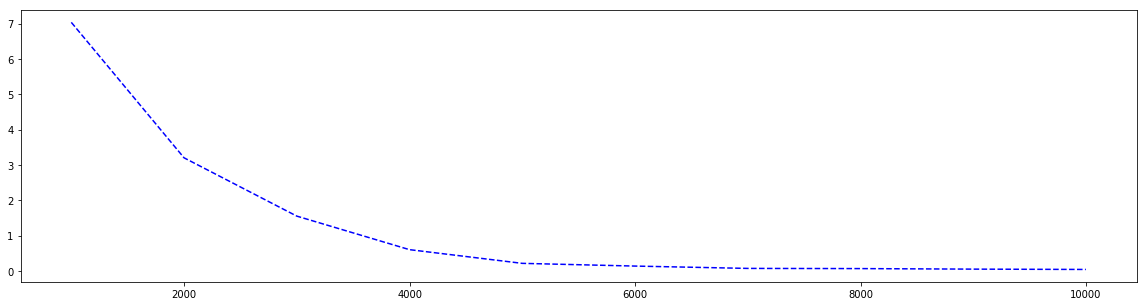

In [118]:
plt.figure(figsize=(20,5))
plt.plot(iterations, losses, 'b--')
plt.show()

In [75]:
import seaborn as sns
import pandas as pd

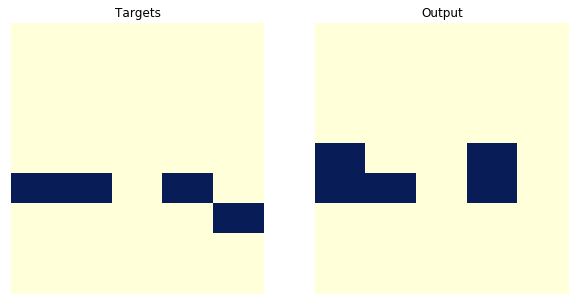

In [119]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set(title="Targets")
_ = sns.heatmap(data=pd.DataFrame(data_res[0].targets[:,0,:]),
                ax=ax[0],
                yticklabels=False, 
                xticklabels=False, 
                cmap="YlGnBu", 
                cbar=False) 
ax[1].set(title="Output")
_ = sns.heatmap(data=pd.DataFrame(outputs[0][:,0,:]),
                ax=ax[1],
                yticklabels=False, 
                xticklabels=False, 
                cmap="YlGnBu", 
                cbar=False) 


In [113]:
NUMB_PLOTS = 9
NUMB_SUB_PLOTS = 2
# the product of the dim has to be = NUMB_PLOTS
GRID_SPACE_DIM = (3, 3)
GRID_SPACE_SUB_DIM = (1, 2)

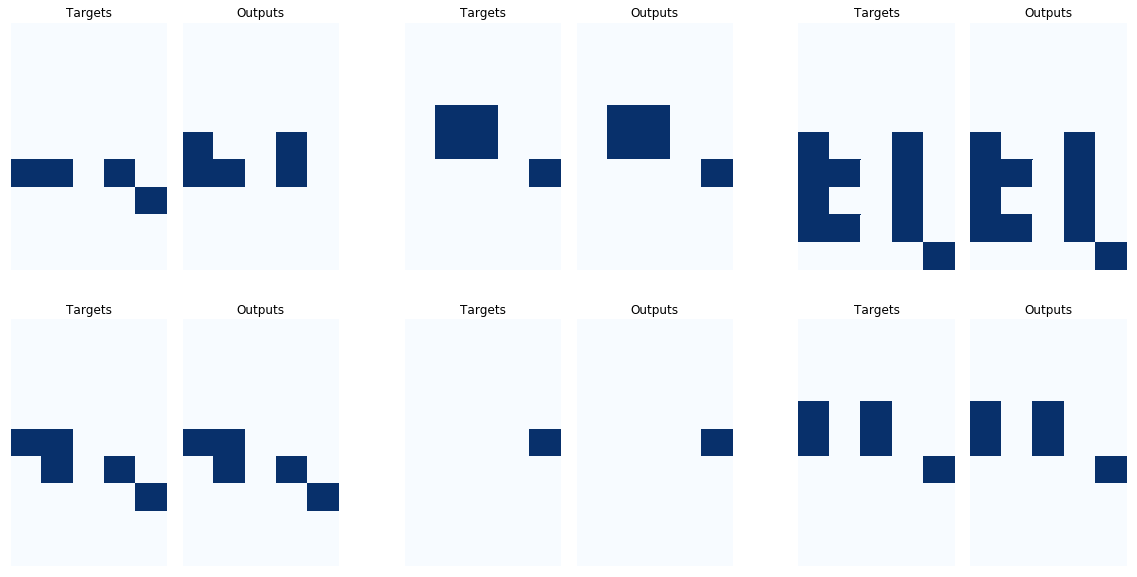

In [123]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 10))
outer = gridspec.GridSpec(GRID_SPACE_DIM[0], GRID_SPACE_DIM[1], wspace=0.2, hspace=0.2)

for i in range(NUMB_PLOTS):
    inner = gridspec.GridSpecFromSubplotSpec(GRID_SPACE_SUB_DIM[0], GRID_SPACE_SUB_DIM[1],
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    for j in range(NUMB_SUB_PLOTS):
        ax = plt.Subplot(fig, inner[j])
        if j%2 == 0:
            ax.set(title="Targets")
            data = data_res[i].targets[:,0,:]
        else:
            ax.set(title="Outputs")
            data = outputs[i][:,0,:]
        _ = sns.heatmap(data=pd.DataFrame(data),
                ax=ax,
                yticklabels=False, 
                xticklabels=False, 
                cmap="Blues", 
                cbar=False) 
        fig.add_subplot(ax)

fig.show()

In [88]:
pd.DataFrame(outputs[0][:,0,:])

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0
5,1.0,1.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0


In [ ]:
NOISE_LEVEL = 85.
TRAINING_ITER = 100000
REPORT_INTERV = 5000

training = Training(HIDDEN_SIZE, MEMORY_SIZE, WORD_SIZE, NUM_WRITE_HEADS, NUM_READ_HEADS, 
                   CLIP_VALUE, MAX_GRAD_NORM, LEARN_RATE, OPTIMIZER_EPSY, BATCH_SIZE, 
                   NUMB_BITS, MIN_LENGTH, MAX_LENGTH, MIN_REPEATS, MAX_REPEATS)

tf.reset_default_graph()
tf.logging.set_verbosity(3)  # Print INFO log messages.
results_noise = training.train(TRAINING_ITER, REPORT_INTERV, with_noise=False, with_distorsion=False, 
                               noise_level=NOISE_LEVEL)

This *matrix* shows the number of changed bits. It has to be red as follow: there is one row per iteration saved and one column for each batch. Take into account that for each iteration 16 batched are generated, in this case only one has been affected by noise

In [ ]:
for indx in range(len(results_noise['data'])):
    print(results_noise['data'][indx][4])

Here instead we show the result for each saved iteration. It's possible to observe the observation, which is the input of the DNC and the model output with the respect of the target. To be noticed, the last two rows in the observation are the termination channel and the repetition channel respectively. For the model output the last row is the termination channel. Those channel are not part of the array to be copied but just extra information passed to the DNC conroller.

for string, iteration, loss in zip(results_noise['strings'], 
                                   results_noise['iteration'],
                                   results_noise['losses']):
    print('\n>>>> Iteration: ' + str(iteration))
    print(string)
    print('>>>> Losses: '+ str(loss))
    

#### Comments
It's possible to see how the noised version is slower in converge to a zero error. We should look for longer training iterations in order to see how much it will improve and if this has some noticeble effects on the copy task. Indeed, for now, even in the case of some noise, the DNC was able to copy the vector without errors in the observed iterations. Further, we should investigate different velues of the noise and different parameter of the task (like increasing the size of the array).

<hr>

## Graph Task
Now we propose an implementation for the **Graph Tasks** as described in the paper. 
Before proceding with the code we provided some implementation design choices for the tasks.
<br>

### Graph Task Description
The idea is to perform the following tasks on a graph:
- Traversal 
- Shortest Path
- Inference

All tasks need a random generation of graph triples consisting of a *source label*, *edge label*, *destination label*. To achieve so, we first generate a random graph by sampling the unit square *N* nodes. Then, *N* numbers are drawn uniformly between $0$ and $999$ and assign randomly to the nodes. This makes the node labels to be unique across the nodes of the network. To decide the neighbors of each node, the KNN (K-nearest neighbour) is used. Once selected the possible neihbours, edges are created between the nodes. Each edge for the neigbourhood is given a label which is a random number among the $N$ already selected for the nodes. For the **Traversal** and the **Shortest Path**, the *edge label* is unique in the neighborhood but not unique in the graph. This means that the DNC has to infer the possible unique relation between two given nodes and their relative edge.

#### Encoding
In order to provide those labels to the DNC controller, the triples are encode using a **10-way one-hot encoding**. That is, each digit has been encoded using a $10$ bit vector with all zeros except the position which identifies the digit set to $1$. This is done for all the $9$ digit representing a triple creating a **90 bit** vector. There is a **special reserved character** (\_) which indicates that there is no input for the given label, this is represented with the zero vector with the same lengts as if there were a digit.
<br>

#### Phases
For the training, the DNC controller receives sequences, each one representing a triple. The seuqences are divided into four phases:
1. **Descritpion Phase**: used to present to the NN the triples of the graph over which perform the tasks.
2. **Query Phase**: used to present queries to the NN based on the proposed graph.
3. **Planning Phase**: no input are provided here, the phase is used to allow the DNC controller to prepare the answers.
4. **Answer Phase**: a part for the *Shortest Path Task*, no input is presented here. During this phase the DNC outputs the answers for the given queries. In this fase, and only here, also the targets are used to compute the loss and train the network.

In order to distinguish the different phases and indicates a transition, there are two additional bits, called channels, included in the input. The design choice is to let the bit of the first channel to be 1 only when there is a trainsition between the phases, and the bit of the second channel is only set to $1$ during all the **Answer Phase**.

#### Output and Loss
The output of the DNC controller are 90 bits, representing nine softmax distribution over the 10 bits. The loss for given sequences is computed as the sum of the log-probabilities of correctly predicting the bits for the nine digits.
<br>
*Here we have to comment about a possibile error in the paper where the sum is computed from 0 to 9. We have to argue due to this in not complient with what is written before the formula.*
<br>
Given input sequences $\mathbf{x}$ and target $\mathbf{z}$, the loss is computed as follow:
<br>
<br>
    $\mathcal{L}(\mathbf{x},\mathbf{z})=\sum_{t=1}^T \{ A(t) \sum_{d=0}^8 log[Pr(\mathbf{z_{t}^d}|\mathbf{y_{t}^d}) ] \} $
<br>

where $\mathbf{z_{t}^d}$ is the target for the sequence $t$ and for the digit $d$, $\mathbf{y_{t}^d}$ is the output fo the DNC controller for the sequence $t$ and for the digit $d$, $A(t)$ is a binary value whcih indicates when the loss has to be consider valid for the trainign. That is, ths value is $1$ during the **Answer Phase** and $0$ in the other ones. For the implementation we have created a mask for simulating this scenario, the mask entry is set to 1 for those seuqences for whcih the training is required.

The **Network Prediction** is determined as the mode of the output of the single softmax distribution over the 10 bits for each of the nine digits. When the network has finished to output an answer, a special output pattern is given as idicated in the paper. Our choise, as non further detail are provided in the paper, is to output all (\_) characters which means a $90$ bit zero vector as termination pattern. The DNC has been trained also on this special output. 

Finally, as a performance metric, the total right predictions over all possibile ones is given.

### Traversal Task
The first task we implement is the Traversal one. This is based on random walks generated from a random Graph. As we described before, during the **Description Phase** the graph triples are presented to the NN, then a series of Queries and Answer tripels. During the **Query Phase**, the first triple is made of the *source node* and *the edge* label (source label, edge label, \_) with the destination missing. The further triples contains only the *edge label* (\_, edge label, \_). The DNC has to save the save the triples of the graph and infer the right nodes which from a source node connects all the nodes of the random walks. We reming that the *edge labels* are not unique accross the graph. That is, the network has to remember the previous destination node of a triple and use it as source label for the following triple.

#### Utilities
Here we show the functions which are to define particular data manipulations.

In [3]:
def _ten_way_one_hot_encoder(number, dim=3):
    """TODO"""
    if number is not None:
        encoded = []
        for digit in str(number).zfill(3):
            zeros = [0] * 10
            zeros[int(digit)] = 1
            encoded += zeros
        return np.array(encoded, dtype=np.int8)
    else:
        return np.zeros(10 * dim, dtype=np.int8)


def _ten_way_one_hot_decoder(vector, dim=3):
    """TODO"""
    # identify the special vector
    if np.max(vector) == 0:
        return None
    else:
        decoded = ''
        for label_b in vector.reshape((dim, 10)):
            number_vector = np.array(range(0, 10))
            value = number_vector.dot(label_b)
            decoded += str(np.max(value))
        return int(decoded)


def _compute_prediction(triple_distribution):
    """TODO"""
    mode_triples = np.argmax(triple_distribution.reshape(9, 10), axis=1).reshape(3, 3)
    labels = []
    for mode_triple in mode_triples:
        for mode in mode_triple:
            zeros = [0] * 10
            zeros[mode] = 1
            labels += zeros
    return np.array(labels)


def _compare_triples(output_logit, target):
    """TODO"""
    triple_output = _compute_prediction(output_logit)
    return np.array_equal(triple_output, target)


def _human_readable_triple(triple):
    """TODO"""
    # treat the None and convert to a string
    restore_triple = []
    for label in triple:
        if label is None:
            restore_triple.append('_')
        else:
            restore_triple.append(str(label))

    return "({}, {}, {})".format(*restore_triple)


def encode_triple(triple):
    """TODO"""
    encoded = []
    for label in triple:
        encoded.append(_ten_way_one_hot_encoder(label))
    return tuple(encoded)


def decode_triple(triple):
    """TODO"""
    decoded = []
    for label in triple:
        decoded.append(_ten_way_one_hot_decoder(label))
    return tuple(decoded)


def single_array_triple(triple):
    return np.stack(triple).flatten()


def multiple_array_triple(triple, dim=3):
    return np.split(triple, dim)


def evaluate_prediction(outputs, masks, targets):
    """TODO"""
    overall_predicted = []
    # retrieve the size of the batch and the sequences from the output shape
    batch_size = outputs.shape[1]
    sequences = outputs.shape[0]

    for i in range(batch_size):
        predicted = 0
        total = 0
        for k in range(sequences):
            if (masks[k, i] != 0) and np.sum(targets[k, i, :] > 0):
                total += 1
                if _compare_triples(outputs[k, i, :], targets[k, i, :]):
                    predicted += 1
        overall_predicted.append(predicted / total)

    return np.mean(np.array(overall_predicted))


def decode_predictions_with_queries(outputs, observations, targets, masks, query_start_index, batch_index=0):
    """TODO"""
    # isolate the mask for the batch and the queries and answers sequences only
    masks_ = masks[query_start_index:, batch_index]
    outputs_ = outputs[query_start_index:, batch_index, :]
    targets_ = targets[query_start_index:, batch_index, :]
    observations_ = observations[query_start_index:, batch_index, :90]

    final_queries_answers = []

    queries_list = []
    answers_list = []
    targets_list = []
    for i in range(len(masks_)):

        # if the mask is 0 is a query and they are contiguous
        if masks_[i] == 0:
            encoded_vector = multiple_array_triple(observations_[i, :])
            decoded_triple = decode_triple(encoded_vector)
            queries_list.append(decoded_triple)

        # if the mask is 1 and there are less answers than queries
        if masks_[i] == 1 and len(queries_list) != len(answers_list):
            # first retrieve the predictions
            predictions = _compute_prediction(outputs_[i, :])
            # use the decoder to retrieve the triple
            encoded_vector = multiple_array_triple(predictions)
            decoded_triple = decode_triple(encoded_vector)
            answers_list.append(decoded_triple)
            # do the same for the targets
            encoded_vector = multiple_array_triple(targets_[i, :])
            decoded_triple = decode_triple(encoded_vector)
            targets_list.append(decoded_triple)
        # else, it's the 1 for the termination pattern, skip this
        elif len(queries_list) == len(answers_list):
            # save the prediction
            final_queries_answers.append((queries_list, answers_list, targets_list))
            # reset the vectors
            queries_list = []
            answers_list = []
            targets_list = []

    return final_queries_answers


def query_answer_human_readable(queries_answers, max_numb_qa=5):
    """TODO"""
    if max_numb_qa > len(queries_answers) or max_numb_qa == "max":
        max_numb_qa = len(queries_answers)

    queries_answers_strings = []

    for i in range(max_numb_qa):
        string = ""
        queries, answers, targets = queries_answers[i][0], queries_answers[i][1], queries_answers[i][2]

        string += "#### QA {} ####\n".format(str(i))
        string += ">>> Queries:\n"
        for q in queries:
            string += _human_readable_triple(q) + '\n'

        string += ">>> Answers:\n"
        for a in answers:
            string += _human_readable_triple(a) + '\n'

        string += ">>> Targets:\n"
        for t in targets:
            string += _human_readable_triple(t) + '\n'
        string += '\n'

        # append the string
        queries_answers_strings.append(string)

    return queries_answers_strings

#### Graph Generation
The class has been created to reflect the graph creation as described in the paper.
We used the *Networkx* libarary to have a structure to define nodes and edges, which allows for a fast look-up of neighbours and edges for a given node. The class allows also to define the random walks on the graph passing the deepness of the walks. Not all walks are guaranteed to reach the specified deepness, so a length parameter is used to select path all of the same length.

In [5]:
"""Class used to define the graph for the DNC Graph task"""

class GraphGen(object):
    """Class usedto generate a Graph. It supplies also methods for drawing random walks over the graph."""
    def __init__(self, low_knn_bound, upper_knn_bound, numb_nodes, save_folder=None):
        self._low_knn_bound = low_knn_bound
        self._upper_knn_bound = upper_knn_bound
        self._numb_nodes = numb_nodes
        self._save_folder = save_folder
        self._node_mapping = {}
        self._triples = []
        self._random_walks = []
        self._graph = None

    def _get_node(self, coordinate):
        return self._node_mapping[tuple(coordinate)]

    def _edge_knn(self, nodes, labels):
        # define the NN class
        nn = NearestNeighbors()
        nn.fit(nodes)

        for node in self._graph.nodes():
            # draw a number for the k parameter from an uniform distribution
            k = np.random.randint(self._low_knn_bound, self._upper_knn_bound)
            # compute the k nearest neighbor
            coordinates = np.array([self._graph.node[node]['x_coordinates'],
                                    self._graph.node[node]['y_coordinates']])
            _, index = nn.kneighbors(coordinates.reshape(1, 2), n_neighbors=k + 1)
            # given the index we retrieve the coordinates, exclude itself from the list
            # the labels for the edge are not unique across the graph and are drawn from the label
            # previously selected for the nodes
            edge_labels = np.random.choice(labels, size=k, replace=False)
            for neighbor_index, edge_label in zip(index[0, 1:], edge_labels):
                # crete the edge between the current node and the neighbor
                # retrieve the given label for that node
                neighbor = self._get_node(nodes[neighbor_index])
                # create the edge, update the Graph and create the triple
                self._graph.add_edge(int(node), int(neighbor), weigth=1.0, label=int(edge_label))
                self._triples.append((node, edge_label, neighbor))

    def _seek_random_walks(self, node, depth=5):
        triples = []
        node_visited = [node]
        curr_node = node
        while depth:
            # find the neighbours of the node and then shuffle the list
            neighbors = nx.neighbors(self._graph, curr_node)
            random.shuffle(neighbors)
            current_neighbor = None
            # look for a valid neighbor which does not create a loop
            for neighbor in neighbors:
                if neighbor not in node_visited:
                    current_neighbor = neighbor
                    break
            # check if there is a neighbor which is valid
            if current_neighbor is not None:
                edge_label = self._graph[curr_node][current_neighbor]['label']
                # generate the triple
                triples.append((curr_node, edge_label, current_neighbor))
                node_visited.append(current_neighbor)
                # update the current node as the neighbor of the previous one
                curr_node = current_neighbor
                # decrement the depth of the walk
            depth -= 1
        return triples

    def save_graph(self, name):
        if self._save_folder is None:
            raise self._NoSaveFolderException

        nx.write_graphml(self._graph, self._save_folder + '/' + name + ".txt")

    def load_graph(self, name):
        if self._save_folder is None:
            raise self._NoSaveFolderException

        self._graph = nx.read_graphml(self._save_folder + '/' + name + ".txt")

    def draw_graph(self):
        # define an instance of graph
        self._graph = nx.Graph()
        # from the unit square draw uniformly 2-d points
        nodes_sampled = np.random.uniform(size=(self._numb_nodes, 2))

        # for each node, draw a integer form 1 ro 999 as label for the node
        # the label must be unique, in case of an already drawn label,
        node_labels = np.random.choice(range(1, 999), size=self._numb_nodes, replace=False)

        for index, node in enumerate(nodes_sampled):
            # add the mapping between label and coordinate
            self._node_mapping[tuple(node)] = node_labels[index]
            # add the node to the graph with the same id as the label
            self._graph.add_node(int(node_labels[index]), x_coordinates=float(node[0]),
                                 y_coordinates=float(node[1]))

        self._edge_knn(nodes_sampled, node_labels)

    def gen_random_walks(self, length=5, depth=5):
        if length > depth:
            raise self._ParameterException

        if self._graph is None:
            raise self._GraphGenerationException

        # reset the walks
        self._random_walks = []
        for n in self._graph.nodes():
            walk = self._seek_random_walks(n, depth=depth)
            if len(walk) == length:
                self._random_walks.append(walk)

    def show_graph(self):
        plt.figure()
        nx.draw_shell(self._graph, with_labels=True)
        plt.show()

    def shuffle_walks(self):
        random.shuffle(self._random_walks)

    @property
    def get_triples(self):
        return self._triples

    @property
    def get_graph(self):
        return self._graph

    @property
    def get_random_walks(self):
        return self._random_walks

    class _GraphGenerationException(Exception):
        @staticmethod
        def print_message():
            print("Need to generate the Graph before running the random walk!")

    class _ParameterException(Exception):
        @staticmethod
        def print_message():
            print("The length of the walk should be <= the deepness of the generated random walks")

    class _NoSaveFolderException(Exception):
        @staticmethod
        def print_message():
            print("The folder for saving the graph is not defined!")

#### Dataset Traversal Task
The class is used to generate a dataset for the Traversal Task. The idea is to generate a tensor of dimension (seuqence_size, batch_size, input_size) as input of the DNC controller. In order to be complient with the DNC definition as provided in the GitHub repository, the tansor is a **time major** one which is used to allow faster computation in run time. A time major tansor has the dimension of the sequences as first axis and the batch one as second axis. 

By default, 32 random walks are generated, but in case of less random walks possible for the given graph the maximum possible number is used to generate the walks. It's possible to ask for a single or multiple dataset to be creared, in the case of a single one a dictionary is given instrad of a list of dictionaries. For each dataset, the observation (comprasing sequences for all the phases of the task) and targets are given. In addition a mask matrix (sequence_size, batch_size) is given to compute the loss as described above.

For the case when no input are required to the DNC controller, we give a vector of zeros representing the special character describe before. This is also a design choice complient with the fact that the *no input* is described indeed as the zero vector.

In [6]:
"""Class used to generate the Traversal task's dataset."""

class DatasetTraversalGenerator(object):
    def __init__(self, lower_bound, upper_bound, nodes, walk_length, walk_deepness, graph_folder, batch_size=16):
        self._lower_bound = lower_bound
        self._upper_bound = upper_bound
        self._nodes = nodes
        self._walk_length = walk_length
        self._walk_deepness = walk_deepness
        self._genGraph = GraphGen(lower_bound, upper_bound, nodes, save_folder=graph_folder)
        self._genGraph.draw_graph()
        self._genGraph.gen_random_walks(walk_length, walk_deepness)
        self._batch_size = batch_size
        self._query_index_start = None

    def _generate_graph_description(self):
        batch_input_description = []
        for triple in self._genGraph.get_triples:
            # add the channels (ch1 and ch2)
            encoded_triple = np.concatenate(
                (single_array_triple(encode_triple(triple)), np.array([0, 0], dtype=np.int8))
            )
            batch_input_description.append(encoded_triple)
        # generate also the target for the batch (90 zeros and 1 for the mask)
        batch_target_description = np.zeros((len(batch_input_description), 91), dtype=np.int8)
        batch_input_description = np.array(batch_input_description)
        return batch_input_description, batch_target_description

    @staticmethod
    def _generate_query_answer(walk, termination=True):
        queries_walk_input = []
        queries_walk_target = []
        answers_walk_input = []
        answers_walk_target = []

        # the first triple of the walk has to include the source and the label
        first = (walk[0][0], walk[0][1], None)

        # the encoded triple has to include the channel 1 only for the first entry
        first_encoded_query = np.concatenate(
            (single_array_triple(encode_triple(first)), np.array([1, 0], dtype=np.int8))
        )
        # generate the corresponding answer (target) for the query and add the mask
        first_encoded_answer = np.concatenate(
            (single_array_triple(encode_triple(walk[0])), np.array([1], dtype=np.int8))
        )

        queries_walk_input.append(first_encoded_query)
        # generate a null target with zeros
        queries_walk_target.append(np.zeros(91, dtype=np.int8))

        # include the two channels for the input and the transition
        answers_walk_input.append(np.concatenate((np.zeros(90, dtype=np.int8), np.array([1, 1], dtype=np.int8))))
        answers_walk_target.append(first_encoded_answer)

        for triple in walk[1:]:
            # the following triples has to include only the label
            triples_i = (None, triple[1], None)
            encoded_query = np.concatenate(
                (single_array_triple(encode_triple(triples_i)), np.array([0, 0], dtype=np.int8))
            )
            encoded_answer = np.concatenate(
                (single_array_triple(encode_triple(triple)), np.array([1], dtype=np.int8))
            )

            queries_walk_input.append(encoded_query)
            queries_walk_target.append(np.zeros(91, dtype=np.int8))
            # include the fake input for the answer phase with the channel set to 1
            answers_walk_input.append(
                np.concatenate(
                    (np.zeros(90, dtype=np.int8), np.array([0, 1], dtype=np.int8))
                )
            )
            answers_walk_target.append(encoded_answer)

        if termination:
            # need to include the termination target and input
            answers_walk_input.append(
                np.concatenate(
                    (np.zeros(90, dtype=np.int8), np.array([0, 1], dtype=np.int8))
                )
            )
            answers_walk_target.append(
                np.concatenate(
                    (np.zeros(90, dtype=np.int8), np.array([1], dtype=np.int8))
                )
            )

        inputs = np.concatenate(
            (np.array(queries_walk_input), np.array(answers_walk_input))
        )
        targets = np.concatenate(
            (np.array(queries_walk_target), np.array(answers_walk_target))
        )

        return inputs, targets

    def _regenerate_graph(self):
        self._genGraph = GraphGen(self._lower_bound, self._upper_bound, self._nodes)
        self._genGraph.draw_graph()
        self._genGraph.gen_random_walks(self._walk_length, self._walk_deepness)

    def _generate_series_query_answer(self, size=32):
        # select 32 random walks
        if len(self._genGraph.get_random_walks) < size:
            size = len(self._genGraph.get_random_walks)

        # shuffle the vector of walks in order to present them in different order to the DNC
        self._genGraph.shuffle_walks()
        walks = self._genGraph.get_random_walks[0:size]
        batch_input_qa, batch_target_qa = self._generate_query_answer(walks[0])

        for walk in walks[1:]:
            input, target = self._generate_query_answer(walk)
            batch_input_qa = np.concatenate((batch_input_qa, input))
            batch_target_qa = np.concatenate((batch_target_qa, target))

        return batch_input_qa, batch_target_qa

    def _build_batches(self):
        observations = []
        targets = []
        masks = []
        # this can be computed only once and then shuffled because the graph does not change across
        # batches
        input_description, target_description = self._generate_graph_description()
        # save the length of the description sequences
        self._query_index_start = len(input_description)

        for _ in range(self._batch_size):
            # shuffle the input description (the target does not change for the description phase)
            np.random.shuffle(input_description)
            # this have to be computed at each batch generation
            input_qa, target_qa = self._generate_series_query_answer()
            # retrieve the mask from the targets of both description and QA and concatenate
            mask_description_batch = target_description[:, -1]
            mask_qa_batch = target_qa[:, -1]
            masks.append(np.concatenate((mask_description_batch, mask_qa_batch)))
            # isolate only the targets of both description and QA and concatenate
            target_description_batch = target_description[:, :-1]
            target_qa_batch = target_qa[:, :-1]
            targets.append(np.concatenate((target_description_batch, target_qa_batch)))
            # concatenate the inputs
            observations.append(np.concatenate((input_description, input_qa)))

        # reshape in order to have a time-major tensors
        obs, targets, masks = np.array(observations), np.array(targets), np.array(masks)

        obs_ = np.moveaxis(obs, 0, 1)
        targets_ = np.moveaxis(targets, 0, 1)
        masks_ = np.moveaxis(masks, 0, 1)

        return obs_, targets_, masks_

    def generate_batches(self, size=10000):
        datasets_collection = []
        for _ in range(size):
            dataset = {}
            dataset['observations'], dataset['targets'], dataset['masks'] = self._build_batches()
            datasets_collection.append(dataset)
            if size == 1:
                return dataset
            self._regenerate_graph()
        return datasets_collection

    def save_graph_dataset(self, name="graph"):
        self._genGraph.save_graph(name)

    def load_graph_dataset(self, name="graph"):
        self._genGraph.load_graph(name)

    @property
    def query_index_start(self):
        return self._query_index_start

#### Training Traversal
The class used for defining the training. The idea is to train the DNC generating a dataset based on a graph from which all the tripels of the graph are presented to the DNC...

In [161]:
class TrainingTraversal(object):
    def __init__(self, hidden_size, memory_size, word_size, num_write_heads, num_read_heads, clip_value,
                 model_output, max_grad_norm, learning_rate, optimizier_epsy, batch_size, lower_bound, 
                 upper_bound, nodes, walk_length, walk_deepness):
        """TODO"""
        # model parameters
        self._hidden_size = hidden_size 
        self._memory_size = memory_size
        self._word_size = word_size
        self._num_write_heads = num_write_heads
        self._num_read_heads = num_read_heads
        self._clip_value = clip_value
        self._model_output = model_output
        # training parameters
        self._max_grad_norm = max_grad_norm
        self._learning_rate = learning_rate
        self._optimizier_epsy = optimizier_epsy
        # task parameters
        self._batch_size = batch_size
        self._lower_bound = lower_bound
        self._upper_bound = upper_bound
        self._nodes = nodes
        self._walk_length = walk_length
        self._walk_deepness = walk_deepness

    @staticmethod
    def masked_sigmoid_cross_entropy(logits, target, mask):
        """TODO"""
        # compute the cross entropy given the output of the neural network and the targets
        # this implements the loss described above
        xent = tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=logits)
        # sum over the digits (this is the sum over the whole 90 bit-long vector)
        loss_time_batch = tf.reduce_sum(xent, axis=2)
        # sum over the sequences applying a mask to hide the sequences not related with the target
        loss_batch = tf.reduce_sum(loss_time_batch * mask, axis=0)
        # get the batch size using the dimensions of the logits
        batch_size = tf.cast(tf.shape(logits)[1], dtype=loss_time_batch.dtype)
        # compute the loss for the total batch
        loss = tf.reduce_sum(loss_batch) / batch_size
        
        return loss

    
    def run_model(self, input_sequence, output_size):
        """Runs model on input sequence."""

        access_config = {
            "memory_size": self._memory_size,
            "word_size": self._word_size,
            "num_reads": self._num_read_heads,
            "num_writes": self._num_write_heads,
        }
        controller_config = {
            "hidden_size": self._hidden_size,
        }
        clip_value = self._clip_value
        
        dnc_core = _dnc.DNC(access_config, controller_config, output_size, clip_value)
        initial_state = dnc_core.initial_state(self._batch_size)

        output_sequence, _ = tf.nn.dynamic_rnn(
            # instance of a RNN core module
            cell=dnc_core,
            inputs=input_sequence,
            time_major=True,
            initial_state=initial_state)

        return output_sequence
    
    def train(self, num_training_iterations, report_interval, checkpoint_dir, graph_dir, restore=False, 
              generalize=False, performance_thresh=0.7, checkpoint_interval=-1, number_queries_answers=2, 
              verbosity=0):
        """Trains the DNC and periodically reports the loss."""
        
        if verbosity == -1:
            tf.logging.set_verbosity(0)
        
        # placeholders definition (have to be feed during the session
        observations_tensor = tf.placeholder(dtype=tf.float32, shape=(None, self._batch_size, 92))
        masks_tensor = tf.placeholder(dtype=tf.float32, shape=(None, self._batch_size))
        targets_tensor = tf.placeholder(dtype=tf.float32, shape=(None, self._batch_size, 90))
        #  compute the output of the RNN
        output_logits = self.run_model(observations_tensor, self._model_output)
        #  compute the loss with the respect of the target
        train_loss = self.masked_sigmoid_cross_entropy(output_logits, targets_tensor, masks_tensor)
        # get all the variables to train
        trainable_variables = tf.trainable_variables()
        #  compute the gradient
        grads, _ = tf.clip_by_global_norm(
            tf.gradients(train_loss, trainable_variables), self._max_grad_norm)

        # define a global variable
        global_step = tf.get_variable(
            name="global_step",
            shape=[],
            dtype=tf.int64,
            initializer=tf.zeros_initializer(),
            trainable=False,
            collections=[tf.GraphKeys.GLOBAL_VARIABLES, tf.GraphKeys.GLOBAL_STEP])

        #  run the backward gradient propagation
        optimizer = tf.train.RMSPropOptimizer(
            self._learning_rate, epsilon=self._optimizier_epsy)
        # GLOBAL -> this is incremented by one after the minimization (backward) have been executed
        train_step = optimizer.apply_gradients(
            zip(grads, trainable_variables), global_step=global_step)

        # create an instance of Saver to save and restore models
        saver = tf.train.Saver()

        # remove the model if not wanted to restore it but wanted to save it
        if not restore and checkpoint_interval > 0 and os.path.isdir(checkpoint_dir):
            tf.logging.info("Saver: the old model has been deleted!")
            shutil.rmtree(checkpoint_dir)
        # if want to save the new one (no folder found)
        if checkpoint_interval > 0:
            if verbosity == -1:
                print("The model will be checkpointed!")
            else:
                tf.logging.info("Saver: the model will be checkpointed!")
            hooks = [
                tf.train.CheckpointSaverHook(
                    checkpoint_dir=checkpoint_dir,
                    save_steps=checkpoint_interval,
                    saver=saver)
            ]
        else:
            hooks = []

        # Monitored Session will automatically restore the model if there is a checkpoint
        with tf.train.SingularMonitoredSession(
                hooks=hooks, checkpoint_dir=checkpoint_dir) as sess:
            # retrieve the global variable value for the iterartion steps
            start_iteration = sess.run(global_step)
            # ptint information about the previous iteration steps and set the starting interation to 0
            if verbosity == -1:
                print("Training has started!")
            else:
                tf.logging.info("Training: training has started!")
            # create the dataset
            dataset_traversal = DatasetTraversalGenerator(self._lower_bound, self._upper_bound,
                                                          self._nodes, self._walk_length,
                                                          self._walk_deepness, graph_dir,
                                                          self._batch_size)

            # if needed to train a general model there is no need to save the graph
            if not generalize:
                # check if it's wanted to save the graph for future training
                if restore and os.path.isdir(graph_dir):
                    tf.logging.info("Networkx: the graph is loaded!")
                    dataset_traversal.load_graph_dataset()
                else:
                    try:
                        os.mkdir(graph_dir)
                    except OSError:
                        shutil.rmtree(graph_dir)
                        os.mkdir(graph_dir)
                    tf.logging.info("Networkx: the graph is saved!")
                    dataset_traversal.save_graph_dataset()
            
            # result saver
            results = {
                "iterations": [],
                "performances": [],
                "average_loss": [],
                "saved_strings": [],
                "graph": None,
            }
            
            if not generalize:
                results["graph"] = dataset_traversal._genGraph.get_graph
            
            total_loss = 0
            for train_iteration in range(start_iteration, num_training_iterations + start_iteration):
                if generalize:
                    # generate a new graph
                    dataset_traversal._genGraph.draw_graph()
                # generate different random walks at each iterations
                dataset_traversal._genGraph.gen_random_walks()
                # shuffle the observation and generate the walks triple
                dataset = dataset_traversal.generate_batches(size=1)
                # dataset inputs
                observations = dataset['observations']
                targets = dataset['targets']
                masks = dataset['masks']
                # create a feed dictionary for initialize the placeholders
                feed = {observations_tensor: observations, masks_tensor: masks, targets_tensor: targets}
                _, loss, output_log = sess.run([train_step, train_loss, output_logits], feed_dict=feed)
                
                if verbosity != 0:
                    tf.logging.info("Training: iter: {:.5f} | loss: {:3.f}".format(train_iteration, loss))
                
                total_loss += loss

                if (train_iteration + 1) % report_interval == 0:
                    performance = evaluate_prediction(output_log, masks, targets)
                    info = ("Training - iter: {} | avg loss: {:.5f} | perform: {:.3f}%"
                                                .format(train_iteration, 
                                                        total_loss / report_interval, 
                                                        performance * 100)
                           )
                    if verbosity == -1:
                        print(info)
                    else:
                        tf.logging.info(info)
                    
                    
                    results['iterations'].append(train_iteration)
                    results['performances'].append(performance)
                    results['average_loss'].append(total_loss / report_interval)
                    
                    total_loss = 0
                    
                    # decide if save or not the predictions given a threshold
                    if performance_thresh is not None and performance > performance_thresh:
                        # print strings
                        queries_answers = decode_predictions_with_queries(output_log, 
                                                                          observations, 
                                                                          targets, masks,
                                                                          dataset_traversal.query_index_start)

                        strings = query_answer_human_readable(queries_answers, number_queries_answers)
                        results["saved_strings"].append(strings) 
                        for string in strings:
                            tf.logging.info("Results: \n" + string)
                    else:
                        results["saved_strings"].append(None)
        
        return results

#### Test model 
The following class allows to use a trained model to compute prediction given an observation tensor. The tensor should include the graph descritpion phase, the query and answers. In addition, the *evaluate_observations* methods need the mask and the targets to print the obtained results along with the targets.

In [175]:
class TestModel(object):
    """Class used to test the model once has been trained."""
    def __init__(self, hidden_size, memory_size, word_size, num_write_heads, num_read_heads, 
                 clip_value, model_output, batch_size):
    
        # model parameters
        self._hidden_size = hidden_size 
        self._memory_size = memory_size
        self._word_size = word_size
        self._num_write_heads = num_write_heads
        self._num_read_heads = num_read_heads
        self._clip_value = clip_value
        self._model_output = model_output
        self._batch_size = batch_size
        
    
    def run_model(self, input_sequence, output_size):
        """Runs model on input sequence."""

        access_config = {
            "memory_size": self._memory_size,
            "word_size": self._word_size,
            "num_reads": self._num_read_heads,
            "num_writes": self._num_write_heads,
        }
        controller_config = {
            "hidden_size": self._hidden_size,
        }
        clip_value = self._clip_value
        
        dnc_core = _dnc.DNC(access_config, controller_config, output_size, clip_value)
        initial_state = dnc_core.initial_state(self._batch_size)

        output_sequence, _ = tf.nn.dynamic_rnn(
            # instance of a RNN core module
            cell=dnc_core,
            inputs=input_sequence,
            time_major=True,
            initial_state=initial_state)

        return output_sequence
    
    
    def evaluate(self, observations, masks, targets, query_index_start, checkpoint_dir, 
                 verbosity=-1, tmp_dir="./tf/dnc/_tmp/test"):
        """TODO"""
        
        if verbosity == -1:
            tf.logging.set_verbosity(0)
        
        # placeholders definition (have to be feed during the session
        observations_tensor = tf.placeholder(dtype=tf.float32, shape=(None, self._batch_size, 92))
        masks_tensor = tf.placeholder(dtype=tf.float32, shape=(None, self._batch_size))
        targets_tensor = tf.placeholder(dtype=tf.float32, shape=(None, self._batch_size, 90))
        #  compute the output of the RNN
        output_logits = self.run_model(observations_tensor, self._model_output)
        
        loss = TrainingTraversal.masked_sigmoid_cross_entropy(output_logits, targets_tensor, masks_tensor)
        
        # define a global variable
        global_step = tf.get_variable(
            name="global_step",
            shape=[],
            dtype=tf.int64,
            initializer=tf.zeros_initializer(),
            trainable=False,
            collections=[tf.GraphKeys.GLOBAL_VARIABLES, tf.GraphKeys.GLOBAL_STEP])

        # create an instance of Saver to save and restore models
        saver = tf.train.Saver()
            
        # create a tmp directory with the thar has to be used for running the test
        if os.path.isdir(tmp_dir):
            shutil.rmtree(tmp_dir)
        shutil.copytree(checkpoint_dir, tmp_dir)        
        
        hooks = [
            tf.train.CheckpointSaverHook(
                checkpoint_dir=tmp_dir,
                save_steps=1,
                saver=saver)
        ]

        # Monitored Session will automatically restore the model if there is a checkpoint
        with tf.train.SingularMonitoredSession(hooks=hooks, checkpoint_dir=checkpoint_dir) as sess:
            # retrieve the global variable value for the iterartion steps
            start_iteration = sess.run(global_step)
            
            # create a feed dictionary for initialize the placeholders
            feed = {observations_tensor: observations, masks_tensor: masks, targets_tensor: targets}
            output_log, loss = sess.run([output_logits, loss], feed_dict=feed)
            
            performance = evaluate_prediction(output_log, masks, targets)
            if verbosity == -1:
                print("Test: - performances: {:.3f}% - error: {:.3f}".format(performance * 100, loss))
            else:
                tf.logging.info("Test - performances: {:.3f}% - error: {:.3f}"
                                .format(performance * 100, loss))

            queries_answers = decode_predictions_with_queries(output_log,observations,targets, masks,
                                                              dataset_traversal.query_index_start)

            strings = query_answer_human_readable(queries_answers)
            if verbosity != -1:
                for string in strings:
                    tf.logging.info("Predictions: \n" + string)

        # remove the tmp directory with the model once the test has been completed
        shutil.rmtree(tmp_dir)

        results = {
                    "performances": performances,
                    "losses": loss,
                    "saved_strings": strings,
                    "query_answers": queries_answers
        }
        return results

<hr>

### Training a model
Now we test the DNC on a small graph task. To notice, there is a relation between the number of triples and the memory size (especially the number of entries). To avoid large matric computation we train the model on a given graph with a low number of nodes. This ensure a relative low number of triples which can be easily stored using a memory of 128 words. 

In [37]:
# Model parameters
HIDDEN_SIZE = 64
MEMORY_SIZE = 128
WORD_SIZE = 32
NUM_WRITE_HEADS = 1
NUM_READ_HEADS = 4
CLIP_VALUE = 20
MODEL_OUTPU_SIZE = 90

# Optimizer parameters.
MAX_GRAD_NORM = 50
LEARN_RATE = 1e-2
OPTIMIZER_EPSY = 1e-10

# Task parameters
BATCH_SIZE = 16
LOWER_BOUND =  2
UPPER_BOUND = 4
NODES = 20
WALK_LENGTH = 2
WALK_DEEPNESS = 2

# Training options.
TRAINING_ITER = 200
REPORT_INTERV = 10
CHECHK_POINT_DIR = "./tf/dnc/traversal_1"
GRAPH_SAVE_DIR = "./nx/dnc/traversal_1"
CHECK_POINT_INTERVAL = 100

In [39]:
training = TrainingTraversal(HIDDEN_SIZE, MEMORY_SIZE, WORD_SIZE, NUM_WRITE_HEADS, NUM_READ_HEADS, 
                   CLIP_VALUE, MODEL_OUTPU_SIZE, MAX_GRAD_NORM, LEARN_RATE, OPTIMIZER_EPSY, BATCH_SIZE, 
                   LOWER_BOUND, UPPER_BOUND, NODES, WALK_LENGTH, WALK_DEEPNESS)

tf.reset_default_graph()
results1 = training.train(TRAINING_ITER, REPORT_INTERV, CHECHK_POINT_DIR, GRAPH_SAVE_DIR, 
                          checkpoint_interval=CHECK_POINT_INTERVAL, performance_thresh=None, 
                          restore=True, verbosity=-1)

The model will be checkpointed!
Training has started!
Training - iter: 2749 | avg loss: 39.8158187866 | perform: 88.269%
Training - iter: 2759 | avg loss: 119.54383297 | perform: 91.471%
Training - iter: 2769 | avg loss: 74.6005970001 | perform: 94.062%
Training - iter: 2779 | avg loss: 86.5886459351 | perform: 89.519%
Training - iter: 2789 | avg loss: 87.6339599609 | perform: 94.514%
Training - iter: 2799 | avg loss: 79.5990840912 | perform: 91.429%
Training - iter: 2809 | avg loss: 105.269802856 | perform: 91.875%
Training - iter: 2819 | avg loss: 71.128194046 | perform: 92.917%
Training - iter: 2829 | avg loss: 82.9137710571 | perform: 95.714%
Training - iter: 2839 | avg loss: 82.104460907 | perform: 96.172%
Training - iter: 2849 | avg loss: 79.8881052017 | perform: 95.804%
Training - iter: 2859 | avg loss: 71.524584198 | perform: 97.171%
Training - iter: 2869 | avg loss: 86.9411605835 | perform: 99.327%
Training - iter: 2879 | avg loss: 85.4672058105 | perform: 93.828%
Training - i

In [40]:
iterations = np.array(results1['iterations'])
performances = np.array(results1['performances'])

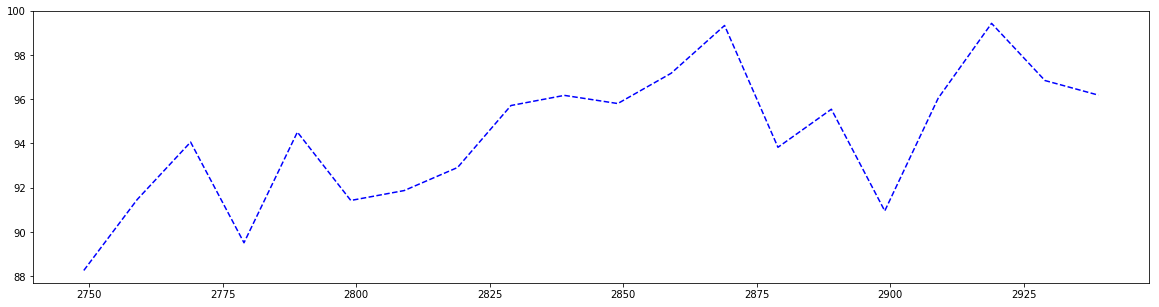

In [41]:
plt.figure(figsize=(20,5))
plt.plot(iterations, performances*100, 'b--')
plt.show()

<hr>

### Using the trained model
Once trained, the model can be used to make predictions on a given observation. It needs also a mask and a target.
The model is loaded from a given folder.

In [168]:
HIDDEN_SIZE = 64
MEMORY_SIZE = 128
WORD_SIZE = 32
NUM_WRITE_HEADS = 1
NUM_READ_HEADS = 4
CLIP_VALUE = 20
MODEL_OUTPU_SIZE = 90
BATCH_SIZE = 16
GRAPH_SAVE_DIR = "./nx/dnc/traversal_1"
CHECHK_POINT_DIR = "./tf/dnc/traversal_1"

In [169]:
dataset_traversal = DatasetTraversalGenerator(LOWER_BOUND, UPPER_BOUND, NODES, WALK_LENGTH, WALK_DEEPNESS, 
                                              GRAPH_SAVE_DIR, BATCH_SIZE)

dataset_traversal.load_graph_dataset()
# generate different random walks
dataset_traversal._genGraph.gen_random_walks()
# shuffle the observation and generate the walks triple
dataset = dataset_traversal.generate_batches(size=1)


observations = dataset['observations']
targets = dataset['targets']
masks = dataset['masks']
index_start = dataset_traversal.query_index_start

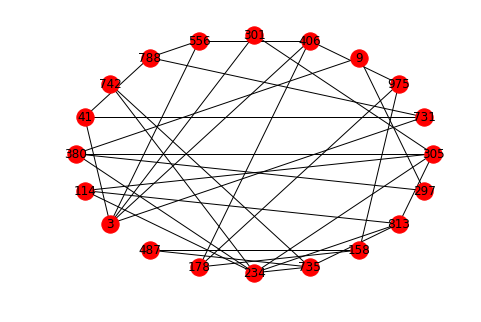

In [170]:
dataset_traversal._genGraph.show_graph()

In [178]:
tf.reset_default_graph()
test_model = TestModel(HIDDEN_SIZE, MEMORY_SIZE, WORD_SIZE, NUM_WRITE_HEADS, NUM_READ_HEADS, 
                       CLIP_VALUE, MODEL_OUTPU_SIZE, BATCH_SIZE)
results_test = test_model.evaluate(observations, masks, targets, index_start, CHECHK_POINT_DIR)

Test: - performances: 91.389% - error: 113.669


In [188]:
results_test["query_answers"][0]

([(975, 9, None),
  (None, 9, None),
  (None, 178, None),
  (None, 813, None),
  (None, 178, None)],
 [(975, 9, 406),
  (406, 9, 178),
  (178, 178, 158),
  (158, 813, 487),
  (487, 178, 735)],
 [(975, 9, 406),
  (406, 9, 178),
  (178, 178, 158),
  (158, 813, 487),
  (487, 178, 735)])

In [182]:
np.array(results_test["query_answers"]).shape

(18, 3, 5, 3)

In [105]:
# Model parameters
HIDDEN_SIZE = 64
MEMORY_SIZE = 128
WORD_SIZE = 32
NUM_WRITE_HEADS = 1
NUM_READ_HEADS = 4
CLIP_VALUE = 20
MODEL_OUTPU_SIZE = 90

# Optimizer parameters.
MAX_GRAD_NORM = 50
LEARN_RATE = 1e-2
OPTIMIZER_EPSY = 1e-10

# Task parameters
BATCH_SIZE = 16
LOWER_BOUND =  2
UPPER_BOUND = 4
NODES = 20
WALK_LENGTH = 2
WALK_DEEPNESS = 2

# Training options.
TRAINING_ITER = 2000
REPORT_INTERV = 50
CHECHK_POINT_DIR = "./tf/dnc/traversal_g"
GRAPH_SAVE_DIR = None
CHECK_POINT_INTERVAL = 50

In [ ]:
training = TrainingTraversal(HIDDEN_SIZE, MEMORY_SIZE, WORD_SIZE, NUM_WRITE_HEADS, NUM_READ_HEADS, 
                   CLIP_VALUE, MODEL_OUTPU_SIZE, MAX_GRAD_NORM, LEARN_RATE, OPTIMIZER_EPSY, BATCH_SIZE, 
                   LOWER_BOUND, UPPER_BOUND, NODES, WALK_LENGTH, WALK_DEEPNESS)

tf.reset_default_graph()
results2 = training.train(TRAINING_ITER, REPORT_INTERV, CHECHK_POINT_DIR, GRAPH_SAVE_DIR, performance_thresh=0.7, 
                          checkpoint_interval=CHECK_POINT_INTERVAL = 50, number_queries_answers=2, 
                          restore=True, generalize=True )

INFO:tensorflow: - RESTORE: The new model will be saved!
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tf/dnc/traversal_g/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 100 into ./tf/dnc/traversal_g/model.ckpt.
INFO:tensorflow: - RESTORE: The previous model iteration stopped: 100.
INFO:tensorflow: - RESTORE: Iteration will restart from 0!
INFO:tensorflow: - TRAINING: Training has started!
INFO:tensorflow: - TRAINING: Iteration: 49 -- Avg loss: 2281.52347168 -- Performances: 0.0 %
INFO:tensorflow:Saving checkpoints for 200 into ./tf/dnc/traversal_g/model.ckpt.
INFO:tensorflow: - TRAINING: Iteration: 99 -- Avg loss: 2256.45018555 -- Performances: 0.0 %
INFO:tensorflow: - TRAINING: Iteration: 149 -- Avg loss: 2151.23311523 -- Performances: 0.0 %
